# Unet_STN_12

## Environment settings

In [1]:
# Basic setting for Jupyter_notebook to import utils
import os
import sys

notebook_path = os.path.abspath("")
project_root = os.path.abspath(os.path.join(notebook_path, "../../"))

sys.path.append(project_root)

In [4]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import scipy.io as sio
from tqdm import tqdm
from utils import folder_utils

In [5]:
# Example usage

country = "GB"
data_folder = "data"
data_test_category = "test_data"
data_read_category = "raw_data"
data_save_category = "processed_data"
output_folder = "ERA5_DATA"
ddeg_out_lat = 0.25
ddeg_out_lon = 0.125

In [6]:
import tensorflow
import keras.backend as K
# from tensorflow.contrib import keras
# from tensorflow.contrib.keras import backend as K

#from data_manager import ClutteredMNIST
#from visualizer import plot_mnist_sample
#from visualizer import print_evaluation
#from visualizer import plot_mnist_grid
# import netCDF4 as nc

from keras.layers import Input, Convolution2D, Convolution1D, MaxPooling2D, Dense, Dropout, \
                          Flatten, concatenate, Activation, Reshape, \
                          UpSampling2D,ZeroPadding2D
import keras
from keras.callbacks import History
history = History()

import keras
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D, Concatenate, ZeroPadding2D
from keras.models import load_model
from keras.layers import Input
from keras.models import Model
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense

from utils import model_utils_tf
from bilinear_interpolation_1x import BilinearInterpolation

D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

## Model loading

In [7]:
def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

In [8]:
losses = []  # Save the loss per epoch
val_losses = []  # Save the val_loss per epoch

In [9]:
def stn(input_shape=(32, 64, 1), sampling_size=(8, 16), num_classes=10):
    inputs = Input(shape=input_shape)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool2)
#     conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)


    conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)
#     conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv5)
    
    locnet = Flatten()(conv5)
    locnet = Dense(500)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(200)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([inputs, locnet])


    up6 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(x)), conv2])
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv6)

    up7 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv6)), conv1])
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv7)



    conv10 = Convolution2D(1, 5, 5, activation='linear',border_mode='same')(conv7)

    model = Model(input=inputs, output=conv10)



    return model

In [10]:
model = stn()
model.compile(loss='mse', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  import sys
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 64, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 64, 32)   25632       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), activation="linear", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


## File loading

In [ ]:
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.test.is_gpu_available())

In [11]:
fileList_train = []
fileList_validation =[]
fileList_test=[]
input_folder_path = folder_utils.find_folder(
    country, data_folder, data_save_category, output_folder
)

for year in range (1979,2021):
    file_path =  os.path.join(input_folder_path, f"era5_pressure_level_{year}_regrid_filter_850.nc")
    fileList_train.append (file_path)
    
fileList_validation.append(os.path.join(input_folder_path, f"era5_pressure_level_2021_regrid_filter_850.nc"))
fileList_test.append(os.path.join(input_folder_path, f"era5_pressure_level_2022_regrid_filter_850.nc"))


In [12]:
input_folder_path

'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA'

In [13]:
fileList_train

['F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1979_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1980_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1981_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1982_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1983_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1984_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1985_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\p

In [14]:
# Calculated constants
M = 273.77817
sdev = 2.5819736

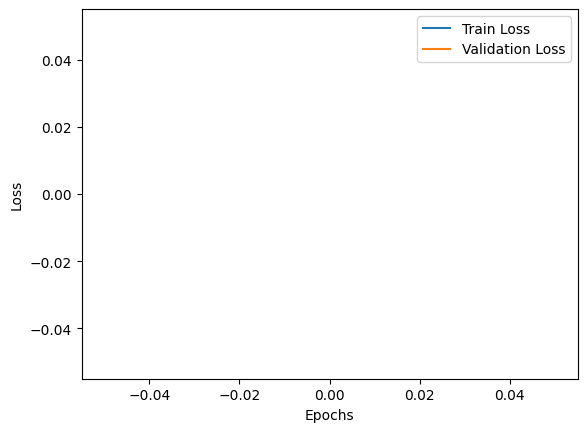

In [15]:
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
File=nc.Dataset(fileList_train[0])
File

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    regrid_method: bilinear
    Conventions: CF-1.6
    history: 2023-08-26 11:48:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1693050523.9571652-30807-11-9f2e4cee-f5dd-4cb7-bd14-d8cfa9322780.nc /cache/tmp/9f2e4cee-f5dd-4cb7-bd14-d8cfa9322780-adaptor.mars.internal-1693050488.2242575-30807-18-tmp.grib
    dimensions(sizes): time(8760), lat(32), lon(64)
    variables(dimensions): float32 t(time, lat, lon), int32 time(time), float64 lon(lon), float64 lat(lat)
    groups: 

In [17]:
Z=np.asarray(File['t'])
# Filter out zero and NaN values
Z.shape

(8760, 32, 64)

In [19]:
batch_size = 10
num_epochs = 8
lead=12
count=0

In [ ]:
batch_size = 10
num_epochs = 8
lead=12
count=0
for loop in tqdm(fileList_train, desc="Processing files"):
    print('******************** counter*************',count)
    File=nc.Dataset(loop)
    Z=np.asarray(File['t'])
    
# # Create a mask to filter out samples with NaN values
#     mask = np.all(~np.isnan(Z), axis=(1, 2))
#     Z = Z[mask]
    
    trainN=np.size(Z,0)-300
    Z=(Z-M)/sdev
    
    
    x_train=Z[0:trainN,:,:]
    x_train=x_train.reshape([np.size(x_train,0),32,64,1])
    y_train=Z[lead:trainN+lead,:,:]
    y_train=y_train.reshape([np.size(y_train,0),32,64,1])
    
    x_val= Z[trainN+lead:np.size(Z,0)-lead,:,:]
    x_val=x_val.reshape([np.size(x_val,0),32,64,1])
    
    y_val= Z[trainN+lead*2:np.size(Z,0),:,:]
    y_val=y_val.reshape([np.size(y_val,0),32,64,1])

    if (count>0):
        
        model = stn()
        model.compile(loss='mse', optimizer='adam')
        # Modify the HDF5 file before loading weights
#         modify_h5_file('best_weights_lead12.h5')

        model.load_weights('best_weights_lead12.h5')
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )
        losses.extend(hist.history['loss'])
        val_losses.extend(hist.history['val_loss'])

    else:
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )
        losses.extend(hist.history['loss'])
        val_losses.extend(hist.history['val_loss'])


    count=count+1

Processing files:   0%|                                                                         | 0/42 [00:00<?, ?it/s]D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  import sys
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\p

******************** counter************* 1


D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update you

Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 142s 17ms/step - loss: 4.0010 - val_loss: 0.7709

Epoch 00001: val_loss improved from inf to 0.77087, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 146s 17ms/step - loss: 3.9174 - val_loss: 0.7360

Epoch 00002: val_loss improved from 0.77087 to 0.73603, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 147s 17ms/step - loss: 3.7878 - val_loss: 0.8454

Epoch 00003: val_loss did not improve from 0.73603
Epoch 4/20
8460/8460 [==============================] - 149s 18ms/step - loss: 3.7374 - val_loss: 0.8584

Epoch 00004: val_loss did not improve from 0.73603
Epoch 5/20
8460/8460 [==============================] - 151s 18ms/step - loss: 3.6514 - val_loss: 0.8851

Epoch 00005: val_loss did not improve from 0.73603
Epoch 6/20
8460/8460 [==============================] - 156s 18ms/step - loss: 3.569

Processing files:   2%|█▍                                                          | 1/42 [17:27<11:55:37, 1047.25s/it]


Epoch 00007: val_loss did not improve from 0.73603
******************** counter************* 2
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 152s 18ms/step - loss: 2.1476 - val_loss: 1.2994

Epoch 00001: val_loss improved from inf to 1.29942, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 151s 18ms/step - loss: 2.0732 - val_loss: 1.3515

Epoch 00002: val_loss did not improve from 1.29942
Epoch 3/20
8484/8484 [==============================] - 159s 19ms/step - loss: 2.0241 - val_loss: 1.2476

Epoch 00003: val_loss improved from 1.29942 to 1.24763, saving model to best_weights_lead12.h5
Epoch 4/20
8484/8484 [==============================] - 156s 18ms/step - loss: 1.9795 - val_loss: 1.2462

Epoch 00004: val_loss improved from 1.24763 to 1.24619, saving model to best_weights_lead12.h5
Epoch 5/20
8484/8484 [==============================] - 155s 18ms/step - loss: 1.9180 - val_loss: 1.3

Processing files:   5%|██▊                                                         | 2/42 [40:50<13:57:45, 1256.64s/it]


Epoch 00009: val_loss did not improve from 1.24619
******************** counter************* 3
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 156s 18ms/step - loss: 2.0428 - val_loss: 0.7813

Epoch 00001: val_loss improved from inf to 0.78134, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 156s 18ms/step - loss: 1.9539 - val_loss: 0.6108

Epoch 00002: val_loss improved from 0.78134 to 0.61080, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 155s 18ms/step - loss: 1.9070 - val_loss: 0.7263

Epoch 00003: val_loss did not improve from 0.61080
Epoch 4/20
8460/8460 [==============================] - 151s 18ms/step - loss: 1.8502 - val_loss: 0.8362

Epoch 00004: val_loss did not improve from 0.61080
Epoch 5/20
8460/8460 [==============================] - 153s 18ms/step - loss: 1.8049 - val_loss: 0.7265

Epoch 00005: val_loss did not improve f

Processing files:   7%|████▎                                                       | 3/42 [58:57<12:46:26, 1179.15s/it]


Epoch 00007: val_loss did not improve from 0.61080
******************** counter************* 4
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 162s 19ms/step - loss: 2.7523 - val_loss: 1.0127

Epoch 00001: val_loss improved from inf to 1.01274, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 164s 19ms/step - loss: 2.6083 - val_loss: 1.0634

Epoch 00002: val_loss did not improve from 1.01274
Epoch 3/20
8460/8460 [==============================] - 158s 19ms/step - loss: 2.5175 - val_loss: 1.1019

Epoch 00003: val_loss did not improve from 1.01274
Epoch 4/20
8460/8460 [==============================] - 156s 18ms/step - loss: 2.4395 - val_loss: 0.9205

Epoch 00004: val_loss improved from 1.01274 to 0.92051, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 157s 19ms/step - loss: 2.3458 - val_loss: 0.8886

Epoch 00005: val_loss improved from 0.9

Processing files:  10%|█████▌                                                    | 4/42 [1:32:05<15:49:10, 1498.69s/it]


Epoch 00012: val_loss did not improve from 0.86495
******************** counter************* 5
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 179s 21ms/step - loss: 1.9306 - val_loss: 2.1092

Epoch 00001: val_loss improved from inf to 2.10924, saving model to best_weights_lead12.h5
Epoch 2/20
6300/8460 [=====================>........] - ETA: 44s - loss: 1.7798